In [32]:
import pandas as pd
from brainflow import BoardShim, BrainFlowInputParams, BoardIds
import pandas as pd
from brainflow.data_filter import DataFilter, FilterTypes, AggOperations, NoiseTypes
import numpy as np
from tools import storage
import matplotlib.pyplot as plt

In [24]:
# get pickle from cache
data = [
    storage.getEEGData("squeeze1"),
    storage.getEEGData("rest1"),
    storage.getEEGData("squeeze2"),
    storage.getEEGData("rest2"),
    storage.getEEGData("squeeze3"),
    storage.getEEGData("rest3"),
    storage.getEEGData("squeeze4"),
    storage.getEEGData("rest4"),
]
data = data.T

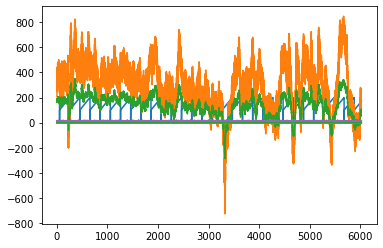

In [81]:
[plt.plot(x) for x in storage.loadEEGData("squeeze")[0:13]]
plt.show()

In [25]:
# chunk data into sliding window
def windowize(data):
    window_size = 250
    window_step = 1
    window_count = int((len(data) - window_size) / window_step) + 1
    print(f"window count: {window_count}")
    data = np.array([data[i*window_step:i*window_step+window_size] for i in range(window_count)])
    print(f"windowed data shape: {data.shape}")
    return data

window count: 1753
windowed data shape: (1753, 250, 15)


In [26]:
data = data.transpose(0, 2, 1)

In [27]:
data.shape

(1753, 15, 250)

/usr/local/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


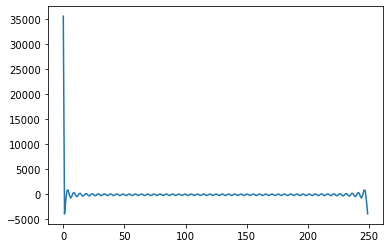

In [30]:
plt.plot(data[0][0])

In [29]:
# fft across each window
data = np.array([np.fft.fft(window) for window in data])
print(f"fft data shape: {data.shape}")

fft data shape: (1753, 15, 250)


In [32]:
data[0][0].shape

(15,)

/usr/local/anaconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


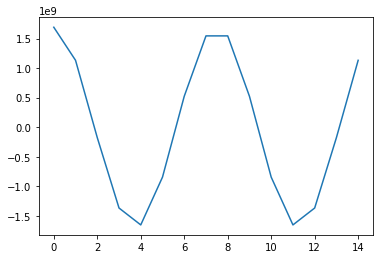

In [33]:
# graph first window
plt.plot(data[0][0])

In [ ]:
# pytorch import neuro cnn classifier
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# dataloader
from torch.utils.data import Dataset, DataLoader

In [ ]:
def Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(250, 250, 5)
        self.pool = nn.MaxPool1d(2, 2)
        self.conv2 = nn.Conv1d(250, 250, 5)
        self.fc1 = nn.Linear(250 * 61, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        x = x.view(-1, 250 * 61)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [ ]:
# SVM
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

labels = []

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# flatten data
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)


# train svm
clf = svm.SVC()
clf.fit(X_train, y_train)

# predict
y_pred = clf.predict(X_test)

print(f"accuracy: {accuracy_score(y_test, y_pred)}")

In [31]:
trainloader = DataLoader(zip(data, labels), batch_size=4, shuffle=True, num_workers=2)

def train(epochs):
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if i % 2000 == 1999:
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 2000}")
                running_loss = 0.0

    print("Finished Training")

NameError: name 'DataLoader' is not defined

In [ ]:
train(5)

In [3]:

data_array = data.to_numpy().T # only because i accidentally trnspoted before
# print(data_array)
 
eeg_channels = list(range(1, 13)) # this is just a placeholder since i dont want to run the board each time
 
 
plt.plot(data_array)
plt.show()
 
# chebyshev filter 
for count, channel in enumerate(eeg_channels): # there are 16 for ours? 
        # filters work in-place
        if count == 0:
            DataFilter.perform_bandpass(data_array[channel], BoardShim.get_sampling_rate(BoardIds.GANGLION_NATIVE_BOARD.value), 2.0, 50.0, 4, FilterTypes.BESSEL_ZERO_PHASE, 0) # cutoff rate and order from docs
        elif count == 1:
            DataFilter.perform_bandstop(data_array[channel], BoardShim.get_sampling_rate(BoardIds.GANGLION_NATIVE_BOARD.value), 48.0, 52.0, 3, FilterTypes.BUTTERWORTH_ZERO_PHASE, 0)
        elif count == 2:
            DataFilter.perform_lowpass(data_array[channel], BoardShim.get_sampling_rate(BoardIds.GANGLION_NATIVE_BOARD.value), 50.0, 5, FilterTypes.CHEBYSHEV_TYPE_1_ZERO_PHASE, 3) # change from 1 to 3 for more variation
        elif count == 3:
            DataFilter.perform_highpass(data_array[channel], BoardShim.get_sampling_rate(BoardIds.GANGLION_NATIVE_BOARD.value), 2.0, 4, FilterTypes.BUTTERWORTH, 0)
        elif count == 4:
            DataFilter.perform_rolling_filter(data_array[channel], 3, AggOperations.MEAN.value)
        else:
            DataFilter.remove_environmental_noise(data_array[channel], BoardShim.get_sampling_rate(BoardIds.GANGLION_NATIVE_BOARD.value), NoiseTypes.FIFTY.value)
# ripple is 3 for 3db, a lot more variation in passband?
 
print(data_array[0:3])

array([[ 0.00000000e+00,  1.01000000e+02,  1.01000000e+02, ...,
         1.95000000e+02,  1.96000000e+02,  1.96000000e+02],
       [ 3.01377968e+02, -1.41874975e+02, -1.75739769e+02, ...,
        -7.72745609e+02, -4.50773882e+02, -4.94919661e+02],
       [ 3.00491612e+02, -1.37607749e+02, -1.77647118e+02, ...,
        -7.66378429e+02, -4.49620122e+02, -5.03220369e+02],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.69289021e+09,  1.69289021e+09,  1.69289021e+09, ...,
         1.69289022e+09,  1.69289022e+09,  1.69289022e+09],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])